# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import keras
keras.__version__

'2.6.0'

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random

from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input
from keras.models import Sequential, Model
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

**LOAD DATA**

In [4]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-10-19 22:57:14--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  32.3MB/s    in 6.8s    

2021-10-19 22:57:21 (32.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [5]:
# Unzipping Data
!gunzip flower_photos.tgz

In [6]:
!tar -xvf flower_photos.tar

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

**Plotting Images**

In [7]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [8]:
len(images) # Number of images

3670

In [9]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [10]:
image_size = 224 # Setting the size of the images

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [11]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.2
)

In [12]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [13]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**VGGNet**

In [14]:
# Instanciate and empty model
model = Sequential()
# First Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same',input_shape=(224,224,3))) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 64
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Second Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(128, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 128
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Third Convolutional Layer
model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(Conv2D(256, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 256
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fourth Convolutional Layer
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# Fith convolutional layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(Conv2D(512, kernel_size=(3,3), activation='relu',padding='same')) # 2D Convolution layer, filters = 512
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2),padding='same')) # MaxPooling layer 
model.add(BatchNormalization()) 
# 1st dense layer
model.add(Flatten()) 
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5)) 
model.add(Activation('relu'))
# 2nd Dense Layer
model.add(Dense(4096))
# Dropout
model.add(Dropout(0.5))
# Normalization
model.add(BatchNormalization()) 
model.add(Activation('relu'))
# Output softmax layer
model.add(Dense(5))
model.add(Activation('softmax')) 

In [15]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

In [17]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=15, verbose=1, shuffle=True)

Epoch 1/15
92/92 [==============================] - 55s 244ms/step - loss: 1.4707 - accuracy: 0.4308 - val_loss: 1.6116 - val_accuracy: 0.1724
Epoch 2/15
92/92 [==============================] - 20s 219ms/step - loss: 1.1881 - accuracy: 0.5451 - val_loss: 1.6160 - val_accuracy: 0.2175
Epoch 3/15
92/92 [==============================] - 20s 220ms/step - loss: 1.0655 - accuracy: 0.5883 - val_loss: 1.6142 - val_accuracy: 0.1724
Epoch 4/15
92/92 [==============================] - 20s 219ms/step - loss: 1.0211 - accuracy: 0.6128 - val_loss: 1.6049 - val_accuracy: 0.2791
Epoch 5/15
92/92 [==============================] - 20s 219ms/step - loss: 0.9201 - accuracy: 0.6550 - val_loss: 1.4174 - val_accuracy: 0.5212
Epoch 6/15
92/92 [==============================] - 20s 218ms/step - loss: 0.8743 - accuracy: 0.6747 - val_loss: 1.2424 - val_accuracy: 0.5622
Epoch 7/15
92/92 [==============================] - 20s 218ms/step - loss: 0.8603 - accuracy: 0.6829 - val_loss: 0.9982 - val_accuracy: 0.5910

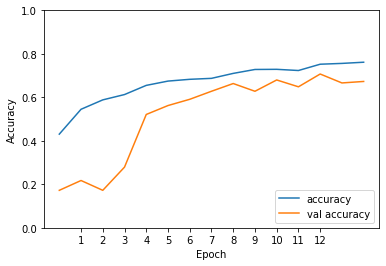

In [19]:
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,13)))
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [21]:
flower_gen_test.reset()
x_test, y_test = next(flower_gen_test)
for i in tqdm(range(int(len(flower_gen_test.labels)/32))):
  img, label = next(flower_gen_test)
  x_test = np.append(x_test, img, axis = 0)
  y_test = np.append(y_test, label, axis = 0)

print(x_test.shape,y_test.shape)

100%|██████████| 22/22 [00:03<00:00,  6.36it/s]

(731, 224, 224, 3) (731, 5)


In [24]:
y_pred = model.predict(x_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [25]:
flower_labels = flower_gen_train.class_indices.keys()
print(flower_labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


In [23]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [26]:
flower_labels = flower_gen_train.class_indices.keys()
print(flower_labels)

dict_keys(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])


Normalized confusion matrix
[[0.66666667 0.03174603 0.18253968 0.         0.11904762]
 [0.02234637 0.68156425 0.05586592 0.12290503 0.11731844]
 [0.015625   0.046875   0.796875   0.0078125  0.1328125 ]
 [0.02877698 0.03597122 0.07194245 0.71942446 0.14388489]
 [0.         0.04402516 0.44025157 0.05031447 0.46540881]]


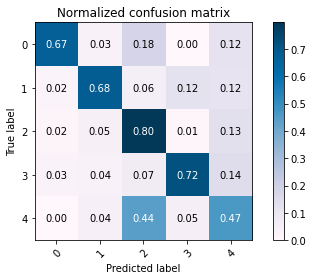

In [27]:
plot_confusion_matrix(y_test, y_pred, classes=np.r_[0,1,2,3,4], normalize=True, cmap=plt.cm.PuBu)